CycleGANのGeneratorをベースにしたもの

In [1]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [2]:
# Simple Convolutional Autoencoder
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import math
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from model import CycleGenerator

In [3]:
GPU_NUM = int(torch.cuda.device_count())
print(GPU_NUM)

2


In [4]:
# Set Hyperparameters

in_channels = 3
out_channels = 3
img_size = (64, 64)
epoch = 20
batch_size = 64
learning_rate = 0.0005

In [5]:
class make_dataset(utils.data.Dataset):
    def __init__(self, img_path):
        self.img_path = img_path + '*.jpg'
        self.images = glob.glob(self.img_path)
        self.transform = transforms.Compose(
            [
            transforms.Resize(img_size),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # 画像読み込み
        image_name = self.images[idx]
        image = Image.open(image_name)
        image = image.convert('RGB') # PyTorch 0.4以降
        return self.transform(image)

In [6]:
train_dataset = make_dataset('/export/data/dataset/COCO/train2014/')
test_dataset = make_dataset('/export/data/dataset/COCO/val2014/')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=GPU_NUM)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=GPU_NUM)

In [7]:
def show_img(inputs,title='images'):
    """Imshow for Tensor."""
    inputs = torchvision.utils.make_grid(inputs[:8], nrow=8)
    inputs = inputs.detach().numpy().transpose((1,2,0))
    plt.figure(figsize=(15,15))
    plt.axis("off")
    plt.title(title)
    plt.imshow(inputs)

In [8]:
def make_mask(p=0.5, s=(0.02, 0.4), r=(0.3, 3)):
    h, w = img_size
    # define mask
    mask = torch.ones([in_channels,w,h])
    
    # determine size of mask at random from the range of s(0,02, 0.4)times of the original image
    mask_area = np.random.randint(h * w * s[0], h * w * s[1])

    # determine aspect ratio of mask at random from the range of r(0.3, 3)
    mask_aspect_ratio = np.random.rand() * r[1] + r[0]

    # determine height and width of mask
    mask_height = int(np.sqrt(mask_area / mask_aspect_ratio))
    if mask_height > h - 1:
        mask_height = h - 1
    mask_width = int(mask_aspect_ratio * mask_height)
    if mask_width > w - 1:
        mask_width = w - 1
        
    # determine position of mask (x1,y1,x2,y2)
    x1 = np.random.randint(0, w - mask_width)
    y1 = np.random.randint(0, h - mask_height)
    x2 = x1 + mask_width
    y2 = y1 + mask_height
    mask[:, y1:y2, x1:x2] = 0
    
    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])


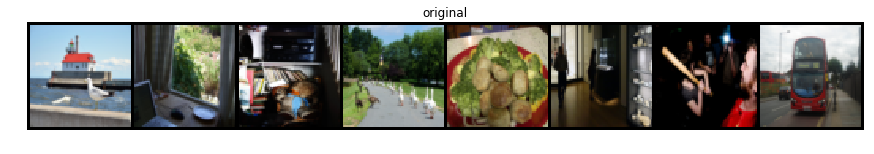

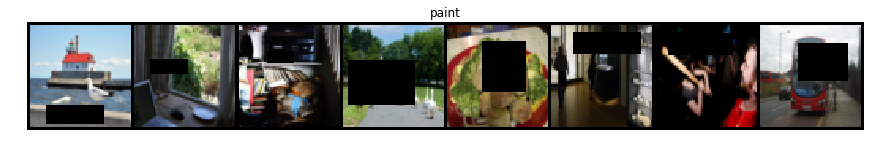

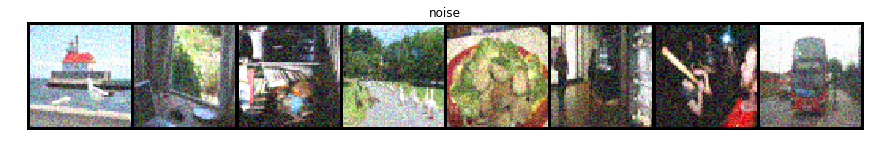

In [9]:
# 画像サンプル
samples = next(iter(test_loader))
show_img(samples, 'original')
print(samples.shape)

mask = torch.stack([make_mask() for i in range(batch_size)], dim=0)
noise = torch.rand(batch_size,in_channels,img_size[0],img_size[1])

samples_paint = torch.mul(samples, mask) # add mask
show_img(samples_paint, 'paint')

samples_noise = torch.add(samples.cpu(), 0.3*noise) # add noise
show_img(samples_noise, 'noise')

## model

In [10]:
model = CycleGenerator(in_channels=in_channels, out_channels=out_channels).cuda()
model = torch.nn.DataParallel(model)

In [11]:
model

DataParallel(
  (module): CycleGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace)
      (10): ResidualBlock(
        (model): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (3): ReLU(inplace)
          (4

## train

In [12]:
# 出力テスト
inputs = next(iter(train_loader))
output = model(inputs.cuda())
print(output.shape)

torch.Size([64, 3, 64, 64])


In [ ]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(model.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [ ]:
# train encoder and decoder
# save and load model
if not os.path.exists('model'):
    os.mkdir('model')
    print("directory maked")
    
load_epoch = 14
try:
    param = torch.load('./model/model_{}.pth'.format(load_epoch))
    model.load_state_dict(param)
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epoch):
    i = i + load_epoch
    for j,images in enumerate(train_loader):
        
        mask = torch.stack([make_mask() for i in range(len(images))], dim=0)
        noise = torch.rand(len(images),in_channels,img_size[0],img_size[1])
        images_noise = torch.add(images.cpu(), 0.3*noise).cuda() # add noise
        images_paint = torch.mul(images, mask).cuda() # add mask
        images = images.cuda()
        
        optimizer.zero_grad()
        
        output_denoising = model(images_noise)
        output_inpainting = model(images_paint)
        #output = autoencoder(images)
        
        loss = loss_func(output_denoising,images) + loss_func(output_inpainting,images)
        #loss = loss_func(output, images)
        loss.backward()
        
        optimizer.step()
        
        if j % 500 == 0:
            print('{}epoch:{}/{},loss:{}'.format(i+1,j,len(train_loader),loss.item()))
        
    if (i+1) % 2 == 0:
        torch.save(model.state_dict(),'./model/model_{}.pth'.format(i+1))


--------model restored--------

15epoch:0/1294,loss:0.009160090237855911
15epoch:500/1294,loss:0.010376425459980965
15epoch:1000/1294,loss:0.011483978480100632
16epoch:0/1294,loss:0.010433451272547245
16epoch:500/1294,loss:0.010365329682826996
16epoch:1000/1294,loss:0.01030546985566616
17epoch:0/1294,loss:0.011451982893049717
